In [1]:
# Import libraries
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import sigmoid, relu
from scipy.cluster.hierarchy import dendrogram, linkage

### Load Data

In [2]:
with open('1016data/sem_items.txt','r') as fid:
    names_items = np.array([l.strip() for l in fid.readlines()])
with open('1016data/sem_relations.txt','r') as fid:
    names_relations = np.array([l.strip() for l in fid.readlines()])
with open('1016data/sem_attributes.txt','r') as fid:
    names_attributes = np.array([l.strip() for l in fid.readlines()])
        
nobj = len(names_items)
nrel = len(names_relations)
nattributes = len(names_attributes)
print(f'num of objects: {nobj}')
print(f'num of relations: {nrel}')
print(f'num of attributes: {nattributes}')

num of objects: 75
num of relations: 14
num of attributes: 218


In [3]:
D = np.loadtxt('1016data/sem_data.txt')
input_pats = D[:,:nobj+nrel]
input_pats = torch.tensor(input_pats,dtype=torch.float)
output_pats = D[:,nobj+nrel:]
output_pats = torch.tensor(output_pats,dtype=torch.float)
N = input_pats.shape[0] # number of training patterns
print(f'num of training examples: {N}')

input_v = input_pats[0,:].numpy().astype('bool')
output_v = output_pats[0,:].numpy().astype('bool')
print('Example input pattern:')
print(input_v.astype('int'))
print('Example output pattern:')
print(output_v.astype('int'))
print("")
print("Which encodes...")
print('Item ',end='')
print(names_items[input_v[:75]])
print('Relation ',end='')
print(names_relations[input_v[75:]])
print('Attributes ',end='')
print(names_attributes[output_v])

num of training examples: 250
Example input pattern:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Example output pattern:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Which encodes...
Item ['exercise']
Relation ['hasprerequisite']
Attributes ['danc' 'jog' 'lift weight' 'move' 'muscl' 'run']


### Neural Network

In [4]:
class Net(nn.Module):
    def __init__(self, rep_size, hidden_size, layer_1_size, hidden_rel_size):
        super(Net, self).__init__()
        self.itol1 = nn.Linear(nobj, layer_1_size)
        self.l1tor = nn.Linear(layer_1_size, rep_size)
        self.reltohr = nn.Linear(nrel, hidden_rel_size)
        self.cattoh = nn.Linear(rep_size+hidden_rel_size, hidden_size)
        self.htoa = nn.Linear(hidden_size, nattributes)

    def forward(self, x):
        x = x.view(-1,nobj+nrel)
        x_pat_item = x[:,:nobj]
        x_pat_rel = x[:,nobj:]
        layer1 = relu(self.itol1(x_pat_item))
        rep = relu(self.l1tor(layer1))
        rel = relu(self.reltohr(x_pat_rel))
        reprel = torch.cat((rep, rel), dim=1)
        hidden = relu(self.cattoh(reprel))
        output = self.htoa(hidden)
        return output, hidden, rep

In [5]:
def train(mynet,epoch_count,nepochs_additional=5000):
    # Input
    #  mynet : Net class object
    #  epoch_count : (scalar) how many epochs have been completed so far
    #  nepochs_additional : (scalar) how many more epochs we want to run
    mynet.train()
    for e in range(nepochs_additional): # for each epoch
        error_epoch = 0.
        perm = np.random.permutation(N)
        for p in perm: # iterate through input patterns in random order
            mynet.zero_grad() # reset gradient
            output, hidden, rep = mynet(input_pats[p,:]) # forward pass
            target = output_pats[p,:] 
            loss = criterion(output, target) # compute loss
            loss.backward() # compute gradient 
            optimizer.step() # update network parameters
            error_epoch += loss.item()
        error_epoch = error_epoch / float(N)        
        if e % 250 == 0:
            print('epoch ' + str(epoch_count+e) + ' loss ' + str(round(error_epoch,7)))
    return epoch_count + nepochs_additional

In [1]:
def get_rep(net):
    # Extract the hidden activations on the Representation Layer for each item
    # 
    # Input
    #  net : Net class object
    #
    # Output
    #  rep : [nitem x rep_size numpy array], where each row is an item
    input_clean = torch.zeros(nobj,nobj+nrel)
    for idx,name in enumerate(names_items):
        input_clean[idx,idx] = 1. # 1-hot encoding of each object (while Relation Layer doesn't matter)
    output, hidden, rep = mynet(input_clean)
    return rep.detach().numpy()


def plot_dendo(rep1,rep2,rep3,names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using hierarchical clustering
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1,nepochs_phase2,nepochs_phase3]
    linked1 = linkage(rep1,'ward')
    linked2 = linkage(rep2,'ward')
    linked3 = linkage(rep3,'ward')
    mx = np.dstack((linked1[:,2],linked2[:,2],linked3[:,2])).max()+5
    plt.figure(2,figsize=(20,15))
    plt.subplots_adjust(hspace=0.7)
    plt.subplot(3,1,1)
    dendrogram(linked1, labels=names, color_threshold=0, leaf_font_size=10)
    plt.ylim([0,mx])
    plt.title('Hierarchical clustering; ' + "epoch " + str(nepochs_list[0]), loc='left')
    plt.subplot(3,1,2)
    plt.title("epoch " + str(nepochs_list[1]), loc='left')
    dendrogram(linked2, labels=names, color_threshold=0, leaf_font_size=10)
    plt.ylim([0,mx])
    plt.subplot(3,1,3)
    plt.title("epoch " + str(nepochs_list[2]), loc='left')
    dendrogram(linked3, labels=names, color_threshold=0, leaf_font_size=10)
    plt.ylim([0,mx])
    plt.savefig('complex.png')
    plt.show()

In [7]:
learning_rate = 0.01
criterion = nn.MultiLabelSoftMarginLoss()
mynet = Net(rep_size=75,hidden_size=200, layer_1_size=75, hidden_rel_size=30)
optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate) # stochastic gradient descent

nepochs_phase1 = 10000
nepochs_phase2 = 30000
nepochs_phase3 = 80000
epoch_count = 0
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase1)
rep1 = get_rep(mynet)
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase2-nepochs_phase1)
rep2 = get_rep(mynet)
epoch_count = train(mynet,epoch_count,nepochs_additional=nepochs_phase3-nepochs_phase2)
rep3 = get_rep(mynet)


epoch 0 loss 0.68942
epoch 250 loss 0.0579592
epoch 500 loss 0.0568788
epoch 750 loss 0.0560295
epoch 1000 loss 0.0553424
epoch 1250 loss 0.0546455
epoch 1500 loss 0.0537297
epoch 1750 loss 0.0525773
epoch 2000 loss 0.0513297
epoch 2250 loss 0.0500627
epoch 2500 loss 0.0488147
epoch 2750 loss 0.0475363
epoch 3000 loss 0.0461628
epoch 3250 loss 0.0447508
epoch 3500 loss 0.0434006
epoch 3750 loss 0.0421528
epoch 4000 loss 0.0409929
epoch 4250 loss 0.0399305
epoch 4500 loss 0.0389761
epoch 4750 loss 0.0381181
epoch 5000 loss 0.0373429
epoch 5250 loss 0.036621
epoch 5500 loss 0.035943
epoch 5750 loss 0.03529
epoch 6000 loss 0.0346524
epoch 6250 loss 0.0340098
epoch 6500 loss 0.0333355
epoch 6750 loss 0.0325753
epoch 7000 loss 0.0316984
epoch 7250 loss 0.0306916
epoch 7500 loss 0.0295906
epoch 7750 loss 0.0284275
epoch 8000 loss 0.0272102
epoch 8250 loss 0.0259804
epoch 8500 loss 0.0247885
epoch 8750 loss 0.0236366
epoch 9000 loss 0.0225175
epoch 9250 loss 0.0213906
epoch 9500 loss 0.020244

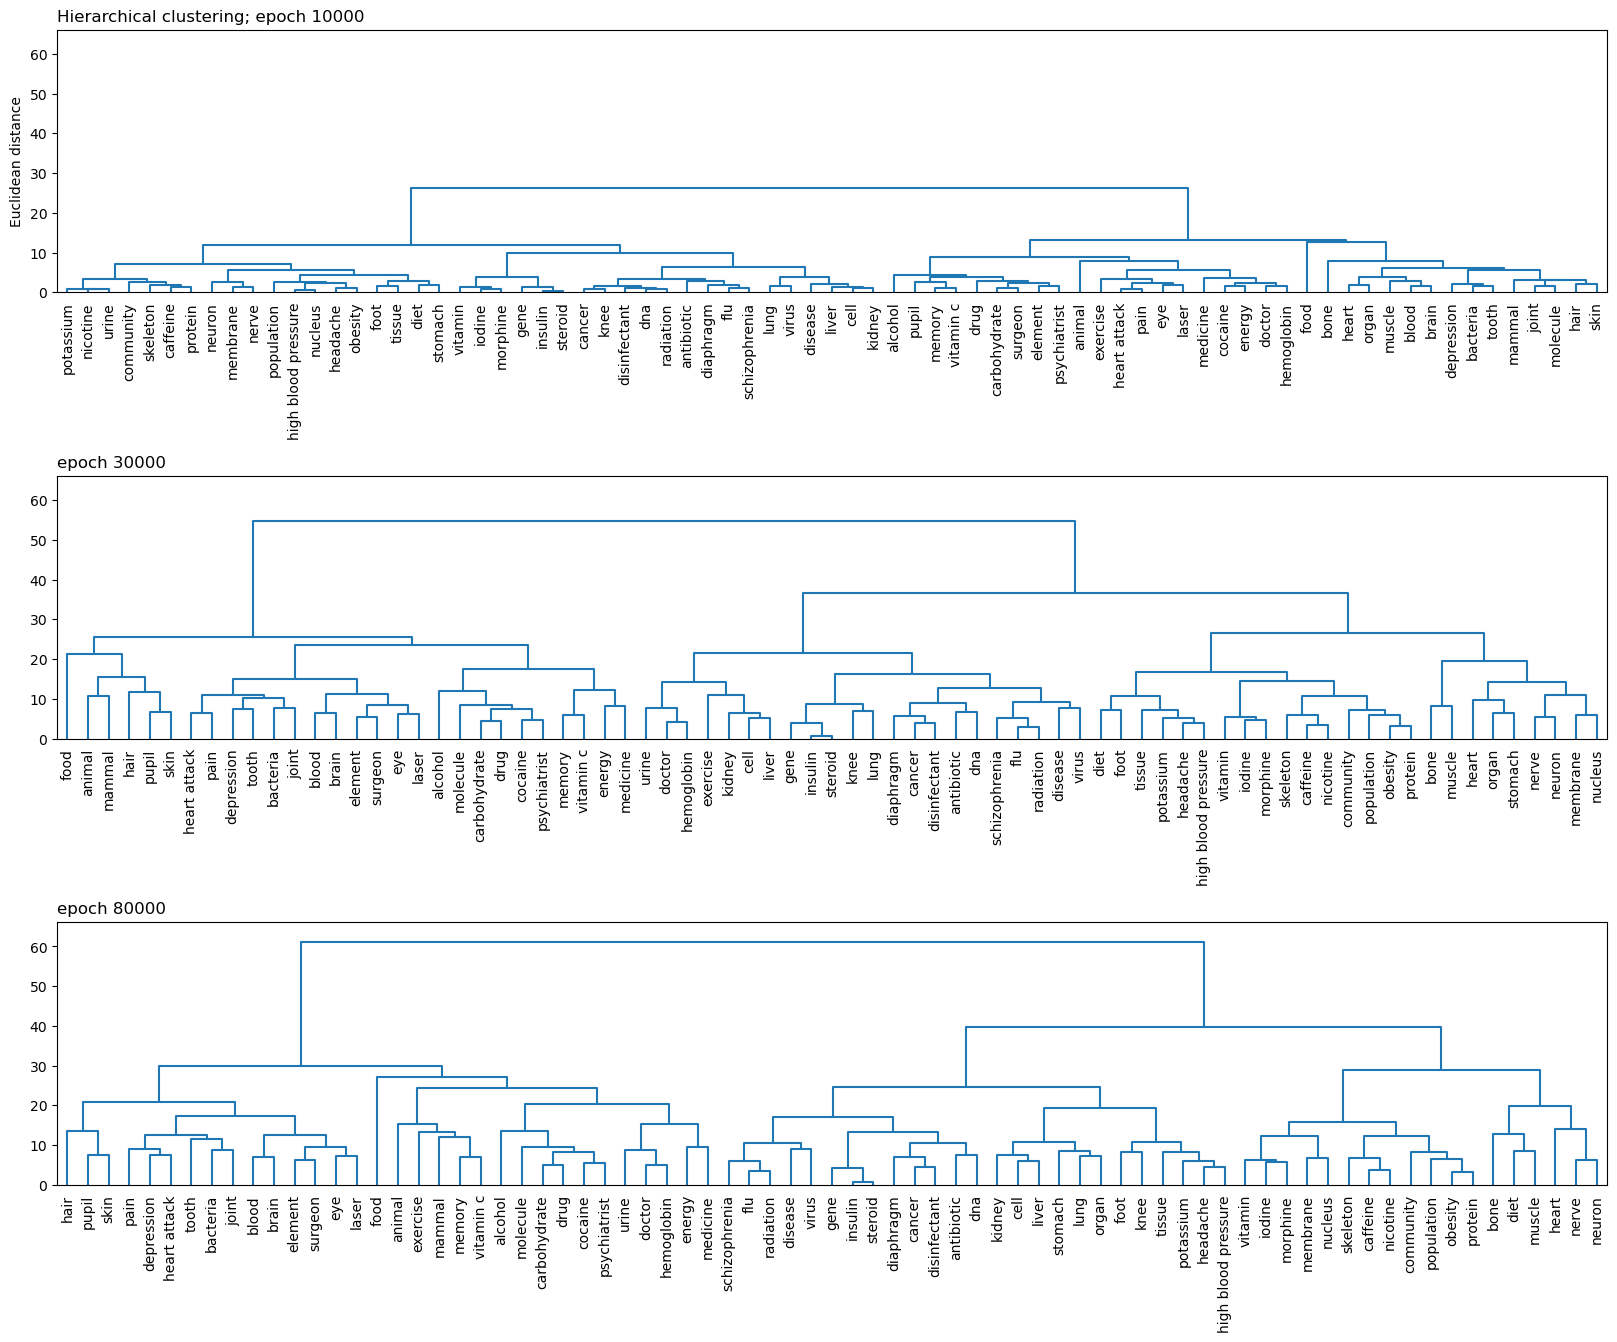

In [16]:
plot_dendo(rep1,rep2,rep3,names_items)

In [39]:
# sanity check

def compare_groundtruth_predictions(i, network):
    """0<=i<=249"""
    network.eval()
    input_v = input_pats[i,:].numpy().astype('bool')
    output_v = output_pats[i,:].numpy().astype('bool')
    print('Example input pattern:')
    print(input_v.astype('int'))
    print('Example output pattern:')
    print(output_v.astype('int'))
    print("")
    print("Which encodes...")
    print('Item ',end='')
    print(names_items[input_v[:75]])
    print('Relation ',end='')
    print(names_relations[input_v[75:]])
    print('Attributes ',end='')
    print(names_attributes[output_v])
    print("")
    print("Model Activations for the true attributes:")
    pred_act = network(input_pats[i,:])[0].detach().numpy()[output_v.reshape(1,218)]
    print(pred_act)
    print("")
    print("Model Predictions:")
    pred_idx = sigmoid(network(input_pats[i,:])[0]).detach().numpy()>=0.5
    pred = names_attributes[pred_idx.reshape(218)]
    print(pred)

In [40]:
compare_groundtruth_predictions(0, mynet)

Example input pattern:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Example output pattern:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Which encodes...
Item ['exercise']
Relation ['hasprerequisite']
Attributes ['danc' 'jog' 'lift weight' 'move' 'muscl' 'run']

Model Activations for the true attributes:
[6.1970897 6.44482   6.2987056 6.3091774 6.6630373 6.6236634]

Model Predictions:
['danc' 'jog' 'lift weight' 'move' 'muscl' 'run']


In [42]:
compare_groundtruth_predictions(1, mynet)

Example input pattern:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Example output pattern:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Which encodes...
Item ['exercise']
Relation ['hassubevent']
Attributes ['breath' 'eat' 'fall' 'lose weight']

Model Activations for the true attributes:
[5.917443  5.4760637 5.9549384 6.2244964]

Model Predictions:
['breath' 'eat' 'fall' 'lose weight']


In [35]:
# save the model
PATH = 'model_complex.pt'
torch.save(mynet.state_dict(), PATH)

In [37]:
# test
loadedNet = Net(rep_size=75,hidden_size=200, layer_1_size=75, hidden_rel_size=30)
loadedNet.load_state_dict(torch.load(PATH))
loadedNet.eval()

Net(
  (itol1): Linear(in_features=75, out_features=75, bias=True)
  (l1tor): Linear(in_features=75, out_features=75, bias=True)
  (reltohr): Linear(in_features=14, out_features=30, bias=True)
  (cattoh): Linear(in_features=105, out_features=200, bias=True)
  (htoa): Linear(in_features=200, out_features=218, bias=True)
)

In [43]:
compare_groundtruth_predictions(1, loadedNet)

Example input pattern:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Example output pattern:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Which encodes...
Item ['exercise']
Relation ['hassubevent']
Attributes ['breath' 'eat' 'fall' 'lose weight']

Model Activations for the true attributes:
[5.917443  5.4760637 5.9549384 6.2244964]

Model Predictions:
['breath' 'eat' 'fall' 'lose weight']
